In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============================================
# 0. 설정
# ============================================

DATA_ROOT = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\data\dataset_2017_to_2020-01"
csv_path  = os.path.join(DATA_ROOT, "depth_0p0.csv")

# history 길이 (7일 또는 30일 중 하나 선택해서 실험)
INPUT_DAYS = 365          # 

# train / test 분리 날짜
CUTOFF_DATE = "2019-01-01"

# 예측 리드타임 (시간 단위): 1시간, 3시간, 7일, 30일
HORIZON_HOURS = [1, 3, 24*7, 24*30]

# SARIMA 차수 (우선 수동으로 두고, 나중에 튜닝 가능)
ORDER = (1, 1, 1)          # (p,d,q)
SEASONAL_PERIOD_DAYS = 365  # 7일 주기 seasonality 라고 가정 (원하면 30, 365 등으로 바꿔보기)
SEASONAL_ORDER = (1, 1, 1) # (P,D,Q)


# ============================================
# 1. CSV 로딩 + time / lat / lon / temp 매핑
#    (이 부분은 네가 쓰던 ARIMA 코드와 거의 동일)
# ============================================

df = pd.read_csv(csv_path)

# depth 컬럼 제거 (있으면)
if "depth" in df.columns:
    df = df.drop(columns=["depth"])

print("원본 컬럼:", list(df.columns))
print(df.head())

cols = list(df.columns)

# time 후보: 이름에 'time'이 들어간 컬럼
time_col_candidates = [c for c in cols if "time" in c.lower()]
lat_col_candidates  = [c for c in cols if "lat"  in c.lower()]
lon_col_candidates  = [c for c in cols if "lon"  in c.lower()]

if time_col_candidates:
    time_col = time_col_candidates[0]
else:
    time_col = cols[0]

if lat_col_candidates:
    lat_col = lat_col_candidates[0]
else:
    lat_col = cols[1]

if lon_col_candidates:
    lon_col = lon_col_candidates[0]
else:
    lon_col = cols[2]

# 나머지 하나를 temp 로 간주
temp_candidates = [c for c in cols if c not in [time_col, lat_col, lon_col]]
if temp_candidates:
    temp_col = temp_candidates[0]
else:
    raise ValueError("수온(temp) 컬럼을 자동으로 찾지 못했습니다. 컬럼 구성을 확인해 주세요.")

print("매핑: time =", time_col, ", lat =", lat_col, ", lon =", lon_col, ", temp =", temp_col)

# 통일된 이름으로 정리
_data = pd.DataFrame({
    "time": df[time_col],
    "lat":  df[lat_col],
    "lon":  df[lon_col],
    "temp": df[temp_col],
})

# 위도/경도 소수 둘째 자리까지 반올림 (이전 코드와 동일)
_data["lat"] = _data["lat"].astype(float).round(2)
_data["lon"] = _data["lon"].astype(float).round(2)

# 시간 파싱
_data["time"] = pd.to_datetime(_data["time"])
_data = _data.sort_values("time").reset_index(drop=True)

# 고유 축
T = np.sort(_data["time"].unique())
Y = np.sort(_data["lat"].unique())
X = np.sort(_data["lon"].unique())

nT, nY, nX = len(T), len(Y), len(X)
print("시간축 길이 nT:", nT)
print("위도 개수 nY:", nY)
print("경도 개수 nX:", nX)

# ============================================
# 2. 텐서 tnsr[y,x,t] 생성 (네 이전 코드 그대로)
# ============================================

_data.rename(columns={"time": "t", "lat": "y", "lon": "x", "temp": "z"}, inplace=True)

t_map = {t: i for i, t in enumerate(T)}
y_map = {y: i for i, y in enumerate(Y)}
x_map = {x: i for i, x in enumerate(X)}

_data["ti"] = _data["t"].map(t_map)
_data["yi"] = _data["y"].map(y_map)
_data["xi"] = _data["x"].map(x_map)

tnsr = np.zeros((nY, nX, nT), dtype=float)

for yi, xi, ti, z in _data[["yi", "xi", "ti", "z"]].itertuples(index=False):
    tnsr[yi, xi, ti] = z

print("원본 tnsr shape:", tnsr.shape)

# 위도 downsampling (이전 코드 그대로)
y_idx_keep = np.arange(0, nY, 2)  # 0,2,4,...
tnsr_ds = tnsr[y_idx_keep, :, :]
Y_ds = Y[y_idx_keep]
nY_ds = len(Y_ds)

print("downsample 후 tnsr_ds shape:", tnsr_ds.shape)  # (nY_ds, nX, nT)

# 이후부터는 tnsr_ds / Y_ds 기준으로 사용
tnsr = tnsr_ds
Y   = Y_ds
nY  = nY_ds
# nX, nT 그대로


# ============================================
# 3. 시간 해상도 / steps_per_day 계산
# ============================================

# T 는 전체 시간축
if len(T) < 2:
    raise ValueError("시간축 길이가 2 미만입니다.")

dt = np.median(np.diff(T)).astype("timedelta64[s]").astype(int)  # 초 단위
dt_hours = dt / 3600.0
print(f"추정 시간 간격: {dt_hours:.3f} 시간")

steps_per_day = int(round(24.0 / dt_hours))
print("하루당 스텝 수:", steps_per_day)

# SARIMA seasonal m
m_season = SEASONAL_PERIOD_DAYS * steps_per_day
full_seasonal_order = (SEASONAL_ORDER[0],
                       SEASONAL_ORDER[1],
                       SEASONAL_ORDER[2],
                       m_season)
print("SARIMA seasonal_order =", full_seasonal_order)

# history / horizon 을 스텝으로 변환
INPUT_STEPS = INPUT_DAYS * steps_per_day

horizon_steps = {}
for h in HORIZON_HOURS:
    k = int(round(h / dt_hours))
    if k < 1:
        k = 1   # 최소 1스텝
    horizon_steps[h] = k

max_horizon_steps = max(horizon_steps.values())
print("INPUT_STEPS:", INPUT_STEPS)
print("horizon_steps (시간→스텝):", horizon_steps)


# ============================================
# 4. train / test 분리 (global 시간축 T 기준)
# ============================================

cutoff = np.datetime64(CUTOFF_DATE)
train_mask = T < cutoff
test_mask  = T >= cutoff

if not np.any(test_mask):
    raise ValueError("test 구간이 없습니다. CUTOFF_DATE를 조정하세요.")

cut_trng = np.max(np.where(train_mask))   # train 마지막 index
first_test_idx = cut_trng + 1

T_train = T[train_mask]
T_test  = T[test_mask]

trng = tnsr[:, :, train_mask]
test = tnsr[:, :, test_mask]

nTrain = trng.shape[2]
nTest  = test.shape[2]

print(f"train 길이: {nTrain}, test 길이: {nTest}")
print(f"train 기간: {T_train[0]} ~ {T_train[-1]}")
print(f"test  기간: {T_test[0]} ~ {T_test[-1]}")


# ============================================
# 5. SARIMA: INPUT_DAYS history → 여러 리드타임 예측
#    (train 끝 시점 기준, 1h / 3h / 7d / 30d ahead)
# ============================================

train_end_idx = cut_trng
train_start_idx = train_end_idx - INPUT_STEPS + 1
if train_start_idx < 0:
    raise ValueError("INPUT_DAYS가 너무 길어서 train 데이터보다 깁니다.")

print("입력 구간(global index):", train_start_idx, "→", train_end_idx)
print("입력 기간:", T[train_start_idx], "~", T[train_end_idx])
print("예측 기준 시점(= train 끝 다음 시점):", T[first_test_idx])

# 리드타임별 예측 결과 저장: 각 리드타임마다 (nY, nX) 2D 맵
pred_maps = {h: np.full((nY, nX), np.nan, dtype=float) for h in HORIZON_HOURS}

for iy in range(nY):
    for ix in range(nX):
        series = tnsr[iy, ix, :].astype(float)

        # history 추출
        hist = series[train_start_idx:train_end_idx+1]

        # 모두 0이면 skip (선대로직과 유사하게)
        if np.allclose(hist, 0):
            continue

        s = pd.Series(hist).replace([np.inf, -np.inf], np.nan)
        s = s.interpolate(limit_direction="both")

        try:
            model = SARIMAX(
                s.values,
                order=ORDER,
                seasonal_order=full_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)

            fc = res.get_forecast(steps=max_horizon_steps)
            yhat = fc.predicted_mean  # 길이 max_horizon_steps

            for h in HORIZON_HOURS:
                k = horizon_steps[h]        # 몇 step 뒤인지
                if k-1 < len(yhat):
                    pred_maps[h][iy, ix] = yhat[k-1]

        except Exception as e:
            last_val = s.values[-1]
            for h in HORIZON_HOURS:
                pred_maps[h][iy, ix] = last_val

print("SARIMA 예측 완료 (INPUT_DAYS =", INPUT_DAYS, "일).")


# ============================================
# 6. 리드타임별 평가 (global T 기준으로 실제와 비교)
#    - train 끝에서 k-step 앞으로 간 시점을 test에서 찾음
# ============================================

eval_indices = {h: first_test_idx + horizon_steps[h] - 1 for h in HORIZON_HOURS}

for h in HORIZON_HOURS:
    idx = eval_indices[h]
    if idx >= len(T):
        print(f"{h}시간 ahead: 평가 index={idx} 가 시간축을 넘어가서 스킵.")
        continue

    actual_map = tnsr[:, :, idx]
    pred_map   = pred_maps[h]
    err_map    = actual_map - pred_map

    mae = np.nanmean(np.abs(err_map))
    print(f"\n=== 리드타임 {h}시간 ahead (INPUT_DAYS={INPUT_DAYS}) ===")
    print("평균 MAE:", mae)

    # heatmap
    vmin, vmax = 0, 30
    vmax_r = np.nanmax(np.abs(err_map))
    vmin_r = -vmax_r

    fig, axes = plt.subplots(1, 3, figsize=(12,4))

    im0 = axes[0].imshow(actual_map, origin="lower", cmap="inferno",
                         vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Actual @ {T[idx]}")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(pred_map, origin="lower", cmap="inferno",
                         vmin=vmin, vmax=vmax)
    axes[1].set_title(f"SARIMA forecast ({h}h ahead)")
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(err_map, origin="lower", cmap="RdBu_r",
                         vmin=vmin_r, vmax=vmax_r)
    axes[2].set_title("Residual (actual - pred)")
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()


원본 컬럼: ['time', 'lat', 'lon', 'water_temp']
                  time    lat        lon  water_temp
0  2017-01-01 00:00:00  36.32  129.43994   13.901999
1  2017-01-01 00:00:00  36.32  129.52002   14.464000
2  2017-01-01 00:00:00  36.32  129.59998   15.462999
3  2017-01-01 00:00:00  36.32  129.67993   15.646000
4  2017-01-01 00:00:00  36.32  129.76001   16.197000
매핑: time = time , lat = lat , lon = lon , temp = water_temp
시간축 길이 nT: 8883
위도 개수 nY: 25
경도 개수 nX: 10
원본 tnsr shape: (25, 10, 8883)
downsample 후 tnsr_ds shape: (13, 10, 8883)
추정 시간 간격: 3.000 시간
하루당 스텝 수: 8
SARIMA seasonal_order = (1, 1, 1, 2920)
INPUT_STEPS: 2920
horizon_steps (시간→스텝): {1: 1, 3: 1, 168: 56, 720: 240}
train 길이: 5758, test 길이: 3125
train 기간: 2017-01-01T00:00:00.000000000 ~ 2018-12-31T21:00:00.000000000
test  기간: 2019-01-01T00:00:00.000000000 ~ 2020-01-31T21:00:00.000000000
입력 구간(global index): 2838 → 5757
입력 기간: 2017-12-29T21:00:00.000000000 ~ 2018-12-31T21:00:00.000000000
예측 기준 시점(= train 끝 다음 시점): 2019-01-01T00:00

C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


원본 컬럼: ['time', 'lat', 'lon', 'water_temp']
                  time    lat        lon  water_temp
0  2017-01-01 00:00:00  36.32  129.43994   13.901999
1  2017-01-01 00:00:00  36.32  129.52002   14.464000
2  2017-01-01 00:00:00  36.32  129.59998   15.462999
3  2017-01-01 00:00:00  36.32  129.67993   15.646000
4  2017-01-01 00:00:00  36.32  129.76001   16.197000
매핑: time = time , lat = lat , lon = lon , temp = water_temp
시간축 길이 nT: 8883
위도 개수 nY: 25
경도 개수 nX: 10
원본 tnsr shape: (25, 10, 8883)
downsample 후 tnsr_ds shape: (13, 10, 8883)
추정 시간 간격: 3.000 시간
하루당 스텝 수: 8
SARIMA seasonal_order = (0, 1, 0, 2920)
horizon_steps (단위: 스텝): {'3h': 1, '1d': 8, '7d': 56, '30d': 240}
train 길이: 5758, test 길이: 3125
train 기간: 2017-01-01T00:00:00.000000000 ~ 2018-12-31T21:00:00.000000000
test  기간: 2019-01-01T00:00:00.000000000 ~ 2020-01-31T21:00:00.000000000
SARIMA 예측 완료.

=== 리드타임 3h ahead ===
평균 MAE: 14.534211539128988


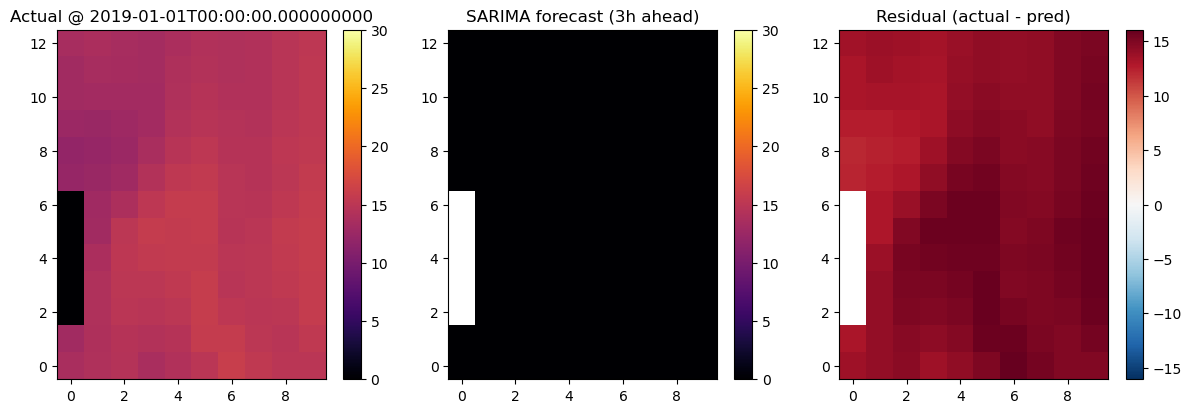


=== 리드타임 1d ahead ===
평균 MAE: 14.578752278896042


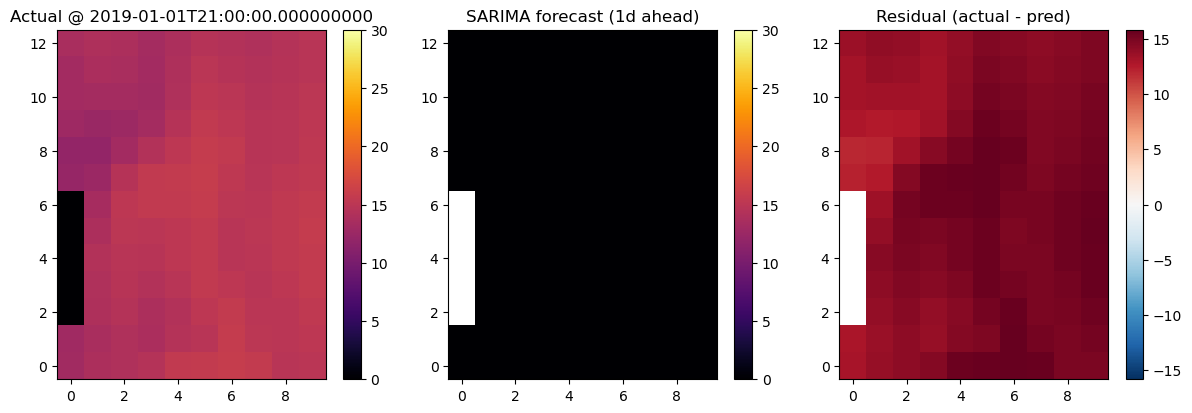


=== 리드타임 7d ahead ===
평균 MAE: 14.078207696


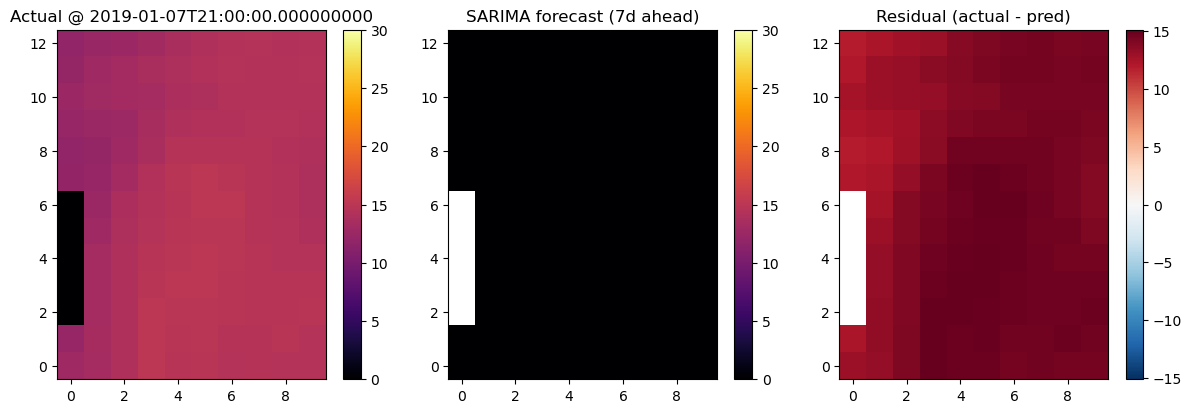


=== 리드타임 30d ahead ===
평균 MAE: 12.677271676


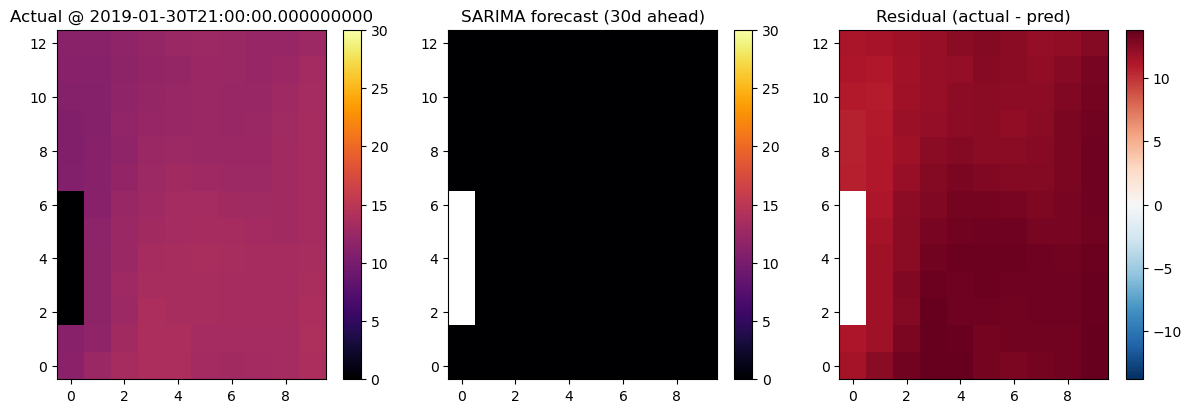

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============================================
# 0. 설정
# ============================================

DATA_ROOT = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\data\dataset_2017_to_2020-01"
csv_path  = os.path.join(DATA_ROOT, "depth_0p0.csv")

# train / test 분리 날짜
CUTOFF_DATE = "2019-01-01"

# SARIMA 차수 (우선 수동, 나중에 auto_arima로 튜닝 가능)
ORDER = (1, 1, 1)          # (p,d,q)
SEASONAL_PERIOD_DAYS = 365 # 1년 주기 seasonality
SEASONAL_ORDER = (0, 1, 0) # (P,D,Q)

# 예측 리드타임 정의 (시간 기준)
HORIZON_HOURS = {
    "3h": 3,
    "1d": 24,
    "7d": 24*7,
    "30d": 24*30,
}

# ============================================
# 1. CSV 로딩 + time / lat / lon / temp 매핑
#    (이전 ARIMA 코드와 동일한 방식)
# ============================================

df = pd.read_csv(csv_path)

# depth 컬럼 제거 (있으면)
if "depth" in df.columns:
    df = df.drop(columns=["depth"])

print("원본 컬럼:", list(df.columns))
print(df.head())

cols = list(df.columns)

# time 후보: 이름에 'time'이 들어간 컬럼
time_col_candidates = [c for c in cols if "time" in c.lower()]
lat_col_candidates  = [c for c in cols if "lat"  in c.lower()]
lon_col_candidates  = [c for c in cols if "lon"  in c.lower()]

if time_col_candidates:
    time_col = time_col_candidates[0]
else:
    time_col = cols[0]

if lat_col_candidates:
    lat_col = lat_col_candidates[0]
else:
    lat_col = cols[1]

if lon_col_candidates:
    lon_col = lon_col_candidates[0]
else:
    lon_col = cols[2]

# 나머지 하나를 temp 로 간주
temp_candidates = [c for c in cols if c not in [time_col, lat_col, lon_col]]
if temp_candidates:
    temp_col = temp_candidates[0]
else:
    raise ValueError("수온(temp) 컬럼을 자동으로 찾지 못했습니다.")

print("매핑: time =", time_col, ", lat =", lat_col, ", lon =", lon_col, ", temp =", temp_col)

# 통일된 이름으로 DataFrame 구성
_data = pd.DataFrame({
    "time": df[time_col],
    "lat":  df[lat_col],
    "lon":  df[lon_col],
    "temp": df[temp_col],
})

# 위도/경도 소수 둘째 자리까지 반올림 (이전 코드와 동일)
_data["lat"] = _data["lat"].astype(float).round(2)
_data["lon"] = _data["lon"].astype(float).round(2)

# 시간 파싱 & 정렬
_data["time"] = pd.to_datetime(_data["time"])
_data = _data.sort_values("time").reset_index(drop=True)

# 고유 축
T = np.sort(_data["time"].unique())
Y = np.sort(_data["lat"].unique())
X = np.sort(_data["lon"].unique())

nT, nY, nX = len(T), len(Y), len(X)
print("시간축 길이 nT:", nT)
print("위도 개수 nY:", nY)
print("경도 개수 nX:", nX)

# ============================================
# 2. 텐서 tnsr[y,x,t] 생성 (기존 코드 그대로)
# ============================================

_data = _data.rename(columns={"time": "t", "lat": "y", "lon": "x", "temp": "z"})

t_map = {t: i for i, t in enumerate(T)}
y_map = {y: i for i, y in enumerate(Y)}
x_map = {x: i for i, x in enumerate(X)}

_data["ti"] = _data["t"].map(t_map)
_data["yi"] = _data["y"].map(y_map)
_data["xi"] = _data["x"].map(x_map)

tnsr = np.zeros((nY, nX, nT), dtype=float)

for yi, xi, ti, z in _data[["yi", "xi", "ti", "z"]].itertuples(index=False):
    tnsr[yi, xi, ti] = z

print("원본 tnsr shape:", tnsr.shape)

# 위도 방향 downsampling (0,2,4,...)
y_idx_keep = np.arange(0, nY, 2)
tnsr_ds = tnsr[y_idx_keep, :, :]
Y_ds = Y[y_idx_keep]
nY_ds = len(Y_ds)

print("downsample 후 tnsr_ds shape:", tnsr_ds.shape)

# 이후 계산은 downsample된 텐서 기준
tnsr = tnsr_ds
Y   = Y_ds
nY  = nY_ds
# nX, nT 는 그대로


# ============================================
# 3. 시간 해상도 / seasonal period / horizon steps 계산
# ============================================

if len(T) < 2:
    raise ValueError("시간축 길이가 2 미만입니다.")

dt = np.median(np.diff(T)).astype("timedelta64[s]").astype(int)  # 초 단위
dt_hours = dt / 3600.0
print(f"추정 시간 간격: {dt_hours:.3f} 시간")  # 여기서 3시간으로 나와야 함

steps_per_day = int(round(24.0 / dt_hours))
print("하루당 스텝 수:", steps_per_day)

# SARIMA seasonal m (1년 = 365일)
m_season = SEASONAL_PERIOD_DAYS * steps_per_day
full_seasonal_order = (SEASONAL_ORDER[0],
                       SEASONAL_ORDER[1],
                       SEASONAL_ORDER[2],
                       m_season)
print("SARIMA seasonal_order =", full_seasonal_order)

# horizon을 스텝으로 변환
horizon_steps = {}
for name, h in HORIZON_HOURS.items():
    k = int(round(h / dt_hours))  # 몇 스텝 뒤인지
    if k < 1:
        k = 1
    horizon_steps[name] = k

max_horizon_steps = max(horizon_steps.values())
print("horizon_steps (단위: 스텝):", horizon_steps)

# ============================================
# 4. train / test 분리
# ============================================

cutoff = np.datetime64(CUTOFF_DATE)
train_mask = T < cutoff
test_mask  = T >= cutoff

if not np.any(test_mask):
    raise ValueError("test 구간이 없습니다. CUTOFF_DATE를 조정하세요.")

cut_trng = np.max(np.where(train_mask))   # train 마지막 index
first_test_idx = cut_trng + 1

T_train = T[train_mask]
T_test  = T[test_mask]

trng = tnsr[:, :, train_mask]
test = tnsr[:, :, test_mask]

nTrain = trng.shape[2]
nTest  = test.shape[2]

print(f"train 길이: {nTrain}, test 길이: {nTest}")
print(f"train 기간: {T_train[0]} ~ {T_train[-1]}")
print(f"test  기간: {T_test[0]} ~ {T_test[-1]}")

# ============================================
# 5. SARIMA: train 전체 → 여러 리드타임 예측
#    - 각 격자별로 train 전체(2017-01-01 ~ 2018-12-31)를 사용해 fit
#    - 그 상태에서 3h, 1d, 7d, 30d ahead 예측
# ============================================

# 리드타임별 예측 결과 저장용: label마다 (nY, nX)
pred_maps = {name: np.full((nY, nX), np.nan, dtype=float)
             for name in HORIZON_HOURS.keys()}

for iy in range(nY):
    for ix in range(nX):
        series = tnsr[iy, ix, :].astype(float)

        # train 구간만 사용
        hist = series[:cut_trng+1]

        # 전부 0이면 skip
        if np.allclose(hist, 0):
            continue

        s = pd.Series(hist).replace([np.inf, -np.inf], np.nan)
        s = s.interpolate(limit_direction="both")

        try:
            model = SARIMAX(
                s.values,
                order=ORDER,
                seasonal_order=full_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing =True
            )
            res = model.fit(disp=False)

            # 최대 리드타임까지 한 번에 예측
            fc = res.get_forecast(steps=max_horizon_steps)
            yhat = fc.predicted_mean  # 길이 max_horizon_steps

            for name, k in horizon_steps.items():
                if k-1 < len(yhat):
                    pred_maps[name][iy, ix] = yhat[k-1]

        except Exception as e:
            # 실패하면 train 마지막 값으로 채우기
            last_val = s.values[-1]
            for name in HORIZON_HOURS.keys():
                pred_maps[name][iy, ix] = last_val

print("SARIMA 예측 완료.")


# ============================================
# 6. 리드타임별 평가 및 heatmap
#    - train 끝에서 k-step 나간 시점을 실제와 비교
# ============================================

eval_indices = {name: first_test_idx + k - 1
                for name, k in horizon_steps.items()}

for name, idx in eval_indices.items():
    if idx >= len(T):
        print(f"{name} ahead: 평가 index={idx} 가 시간축을 넘어가 스킵.")
        continue

    actual_map = tnsr[:, :, idx]       # 실제 SST
    pred_map   = pred_maps[name]       # SARIMA 예측
    err_map    = actual_map - pred_map

    mae = np.nanmean(np.abs(err_map))
    print(f"\n=== 리드타임 {name} ahead ===")
    print("평균 MAE:", mae)

    # heatmap 그리기
    vmin, vmax = 0, 30
    vmax_r = np.nanmax(np.abs(err_map))
    vmin_r = -vmax_r

    fig, axes = plt.subplots(1, 3, figsize=(12,4))

    im0 = axes[0].imshow(actual_map, origin="lower", cmap="inferno",
                         vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Actual @ {T[idx]}")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(pred_map, origin="lower", cmap="inferno",
                         vmin=vmin, vmax=vmax)
    axes[1].set_title(f"SARIMA forecast ({name} ahead)")
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(err_map, origin="lower", cmap="RdBu_r",
                         vmin=vmin_r, vmax=vmax_r)
    axes[2].set_title("Residual (actual - pred)")
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()


원본 컬럼: ['time', 'lat', 'lon', 'water_temp']
                  time    lat        lon  water_temp
0  2017-01-01 00:00:00  36.32  129.43994   13.901999
1  2017-01-01 00:00:00  36.32  129.52002   14.464000
2  2017-01-01 00:00:00  36.32  129.59998   15.462999
3  2017-01-01 00:00:00  36.32  129.67993   15.646000
4  2017-01-01 00:00:00  36.32  129.76001   16.197000
매핑: time = time , lat = lat , lon = lon , temp = water_temp
3시간 텐서: nT = 8883 , nY = 25 , nX = 10
3시간 tnsr_3h shape: (25, 10, 8883)
downsample 후 3시간 텐서 shape: (13, 10, 8883)
일별 시계열 길이 nD: 1125
tnsr_daily shape: (13, 10, 1125)
daily train 길이: 729, test 길이: 396
daily train 기간: 2017-01-01 00:00:00 ~ 2018-12-31 00:00:00
daily test  기간: 2019-01-01 00:00:00 ~ 2020-01-31 00:00:00
daily SARIMA seasonal_order = (0, 1, 0, 365)
horizon_steps_d (단위: 일): {'1d': 1, '7d': 7, '30d': 30}
daily SARIMA 예측 완료.

=== daily 리드타임 1d ahead ===
평균 MAE: 14.4471641232637


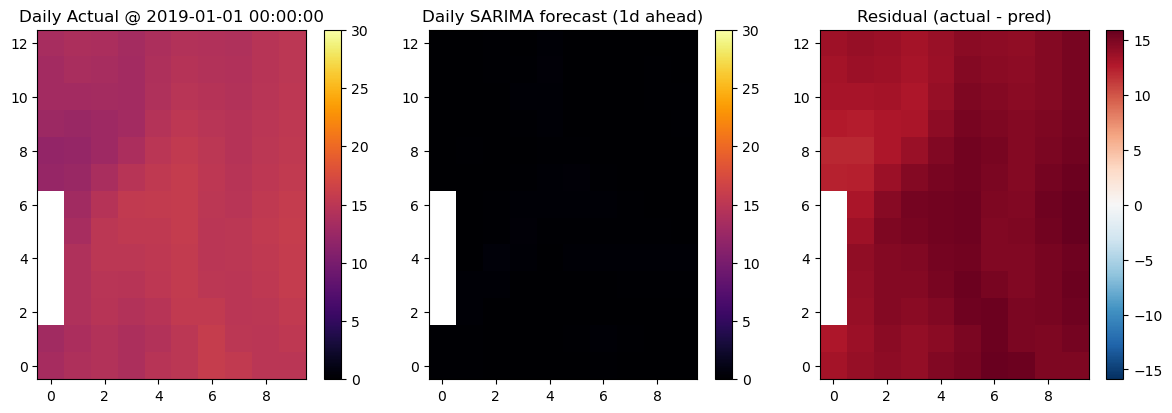


=== daily 리드타임 7d ahead ===
평균 MAE: 14.26455972924691


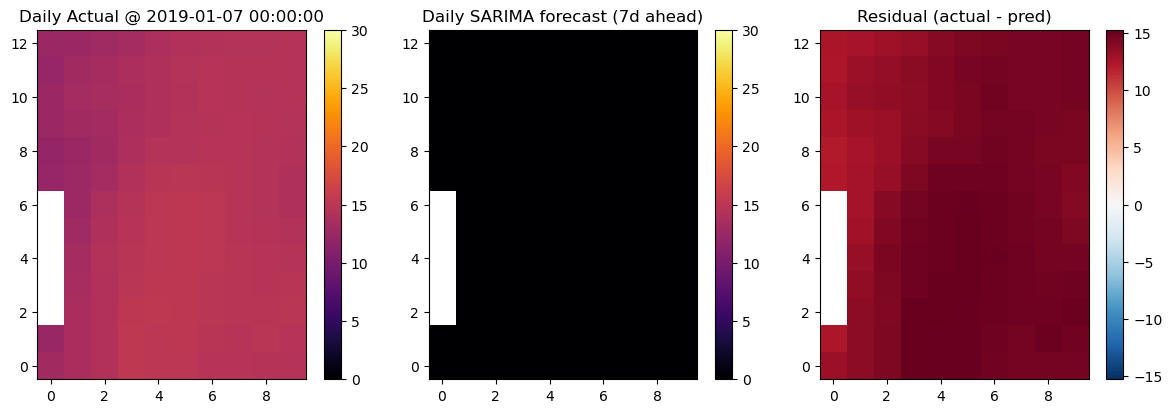


=== daily 리드타임 30d ahead ===
평균 MAE: 12.63868501105275


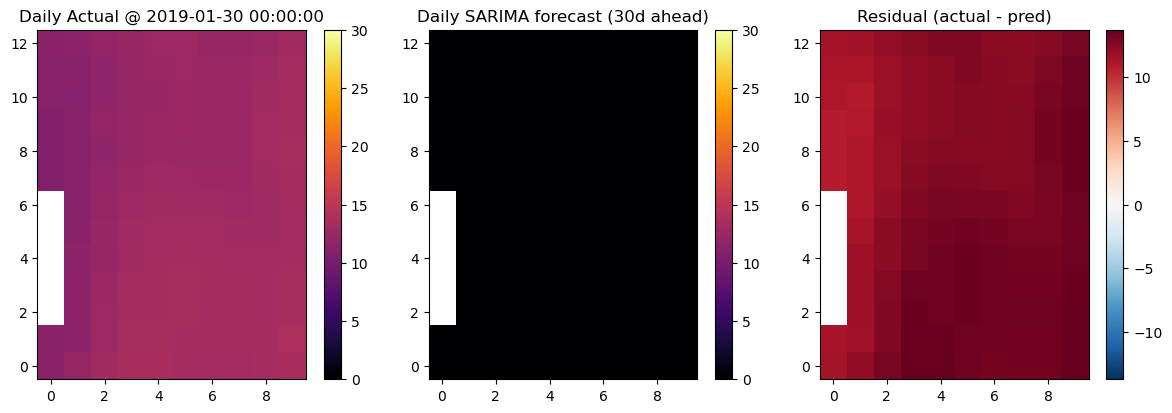

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============================================
# 0. 기본 설정
# ============================================

DATA_ROOT = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\data\dataset_2017_to_2020-01"
csv_path  = os.path.join(DATA_ROOT, "depth_0p0.csv")

CUTOFF_DATE = "2019-01-01"   # train/test 분리 기준 (일 단위도 동일하게 사용)

# SARIMA: 1년 계절성 (일 단위)
ORDER = (1, 1, 1)           # (p,d,q)
SEASONAL_PERIOD_DAYS = 365
SEASONAL_ORDER = (0, 1, 0)  # (P,D,Q) = (0,1,0) → 계절차분만, AR/MA 없음

# 리드타임 (일 단위)
HORIZON_DAYS = {
    "1d": 1,
    "7d": 7,
    "30d": 30,
}

# ============================================
# 1. CSV 로딩 + time/lat/lon/temp 매핑
#    (3시간 텐서 생성까지는 기존과 동일)
# ============================================

df = pd.read_csv(csv_path)

if "depth" in df.columns:
    df = df.drop(columns=["depth"])

print("원본 컬럼:", list(df.columns))
print(df.head())

cols = list(df.columns)

time_col_candidates = [c for c in cols if "time" in c.lower()]
lat_col_candidates  = [c for c in cols if "lat"  in c.lower()]
lon_col_candidates  = [c for c in cols if "lon"  in c.lower()]

time_col = time_col_candidates[0] if time_col_candidates else cols[0]
lat_col  = lat_col_candidates[0]  if lat_col_candidates  else cols[1]
lon_col  = lon_col_candidates[0]  if lon_col_candidates  else cols[2]

temp_candidates = [c for c in cols if c not in [time_col, lat_col, lon_col]]
if not temp_candidates:
    raise ValueError("수온(temp) 컬럼을 자동으로 찾지 못했습니다.")
temp_col = temp_candidates[0]

print("매핑: time =", time_col, ", lat =", lat_col,
      ", lon =", lon_col, ", temp =", temp_col)

_data = pd.DataFrame({
    "time": df[time_col],
    "lat":  df[lat_col].astype(float).round(2),
    "lon":  df[lon_col].astype(float).round(2),
    "temp": df[temp_col],
})

_data["time"] = pd.to_datetime(_data["time"])
_data = _data.sort_values("time").reset_index(drop=True)

# ===== 3시간 텐서 (원래 구조 유지) =====
T_3h = np.sort(_data["time"].unique())
Y = np.sort(_data["lat"].unique())
X = np.sort(_data["lon"].unique())

nT3, nY, nX = len(T_3h), len(Y), len(X)
print("3시간 텐서: nT =", nT3, ", nY =", nY, ", nX =", nX)

# rename for indexing
_data3h = _data.rename(columns={"time": "t", "lat": "y", "lon": "x", "temp": "z"})

t_map3 = {t: i for i, t in enumerate(T_3h)}
y_map = {y: i for i, y in enumerate(Y)}
x_map = {x: i for i, x in enumerate(X)}

_data3h["ti"] = _data3h["t"].map(t_map3)
_data3h["yi"] = _data3h["y"].map(y_map)
_data3h["xi"] = _data3h["x"].map(x_map)

tnsr_3h = np.full((nY, nX, nT3), np.nan, dtype=float)
for yi, xi, ti, z in _data3h[["yi", "xi", "ti", "z"]].itertuples(index=False):
    tnsr_3h[yi, xi, ti] = z

print("3시간 tnsr_3h shape:", tnsr_3h.shape)

# 위도 downsample (0,2,4,...)
y_idx_keep = np.arange(0, nY, 2)
tnsr_3h = tnsr_3h[y_idx_keep, :, :]
Y_ds = Y[y_idx_keep]
nY_ds = len(Y_ds)

print("downsample 후 3시간 텐서 shape:", tnsr_3h.shape)
Y = Y_ds
nY = nY_ds

# ============================================
# 2. 3시간 자료 → 일별 평균 텐서 (daily)
# ============================================

# date 컬럼 생성
_data_daily = _data.copy()
_data_daily["date"] = _data_daily["time"].dt.floor("D")

# daily mean
daily = (_data_daily
         .groupby(["date", "lat", "lon"], as_index=False)["temp"]
         .mean())
daily = daily.sort_values("date").reset_index(drop=True)

#  D를 pandas DatetimeIndex로 만들어서 키 타입을 Timestamp로 통일
D = pd.DatetimeIndex(daily["date"].unique()).sort_values()
nD = len(D)
print("일별 시계열 길이 nD:", nD)

# 인덱스 매핑 (daily)
d_map = {d: i for i, d in enumerate(D)}
y_map = {y: i for i, y in enumerate(Y)}
x_map = {x: i for i, x in enumerate(X)}

# daily 텐서 (lat, lon, day)
tnsr_daily = np.full((nY, nX, nD), np.nan, dtype=float)

# lat/lon rounding 동일하게 맞추기 위해 재변환
daily["lat"] = daily["lat"].astype(float).round(2)
daily["lon"] = daily["lon"].astype(float).round(2)

for _, row in daily.iterrows():
    d  = row["date"]
    yv = float(row["lat"])
    xv = float(row["lon"])
    if (yv in y_map) and (xv in x_map):
        iy = y_map[yv]
        ix = x_map[xv]
        idd = d_map[d]
        tnsr_daily[iy, ix, idd] = float(row["temp"])

print("tnsr_daily shape:", tnsr_daily.shape)

# ============================================
# 3. daily 기준 train/test 분리
# ============================================

cutoff_d = np.datetime64(CUTOFF_DATE)
train_mask_d = D < cutoff_d
test_mask_d  = D >= cutoff_d

if not np.any(test_mask_d):
    raise ValueError("daily 기준 test 구간이 없습니다.")

cut_trng_d = np.max(np.where(train_mask_d))
first_test_idx_d = cut_trng_d + 1

D_train = D[train_mask_d]
D_test  = D[test_mask_d]

trng_daily = tnsr_daily[:, :, train_mask_d]
test_daily = tnsr_daily[:, :, test_mask_d]

nTrain_d = trng_daily.shape[2]
nTest_d  = test_daily.shape[2]

print(f"daily train 길이: {nTrain_d}, test 길이: {nTest_d}")
print(f"daily train 기간: {D_train[0]} ~ {D_train[-1]}")
print(f"daily test  기간: {D_test[0]} ~ {D_test[-1]}")

# ============================================
# 4. SARIMA(1,1,1)×(0,1,0,365) daily 예측
# ============================================

m_season = SEASONAL_PERIOD_DAYS  # 365
full_seasonal_order = (SEASONAL_ORDER[0],
                       SEASONAL_ORDER[1],
                       SEASONAL_ORDER[2],
                       m_season)
print("daily SARIMA seasonal_order =", full_seasonal_order)

# 리드타임 (일 → step)
horizon_steps_d = HORIZON_DAYS.copy()  # 그대로 사용 (단위가 일)

max_horizon_d = max(horizon_steps_d.values())
print("horizon_steps_d (단위: 일):", horizon_steps_d)

# 리드타임별 예측 결과: (nY, nX)
pred_daily_maps = {name: np.full((nY, nX), np.nan, dtype=float)
                   for name in HORIZON_DAYS.keys()}

for iy in range(nY):
    for ix in range(nX):
        series = tnsr_daily[iy, ix, :].astype(float)

        hist = series[:cut_trng_d+1]

        # 유효 데이터 거의 없으면 스킵
        if np.all(np.isnan(hist)) or np.nansum(~np.isnan(hist)) < 30:
            continue

        s = pd.Series(hist).replace([np.inf, -np.inf], np.nan)
        s = s.interpolate(limit_direction="both")

        try:
            model = SARIMAX(
                s.values,
                order=ORDER,
                seasonal_order=full_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True   # d, D 차분을 사전 처리
            )
            res = model.fit(disp=False)

            fc = res.get_forecast(steps=max_horizon_d)
            yhat = fc.predicted_mean

            for name, k in horizon_steps_d.items():
                if k-1 < len(yhat):
                    pred_daily_maps[name][iy, ix] = yhat[k-1]

        except Exception:
            last_val = s.values[-1]
            for name in HORIZON_DAYS.keys():
                pred_daily_maps[name][iy, ix] = last_val

print("daily SARIMA 예측 완료.")

# ============================================
# 5. 리드타임별 평가 (daily 기준)
#    - train 끝에서 k일 나간 시점과 비교
# ============================================

eval_idx_d = {name: first_test_idx_d + k - 1
              for name, k in horizon_steps_d.items()}

for name, idx in eval_idx_d.items():
    if idx >= len(D):
        print(f"{name} ahead: 평가 index={idx} 가 시간축을 넘어가 스킵.")
        continue

    actual_map = tnsr_daily[:, :, idx]
    pred_map   = pred_daily_maps[name]
    err_map    = actual_map - pred_map

    mae = np.nanmean(np.abs(err_map))
    print(f"\n=== daily 리드타임 {name} ahead ===")
    print("평균 MAE:", mae)

    vmin, vmax = 0, 30
    vmax_r = np.nanmax(np.abs(err_map))
    vmin_r = -vmax_r

    fig, axes = plt.subplots(1, 3, figsize=(12,4))

    im0 = axes[0].imshow(actual_map, origin="lower", cmap="inferno",
                         vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Daily Actual @ {D[idx]}")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(pred_map, origin="lower", cmap="inferno",
                         vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Daily SARIMA forecast ({name} ahead)")
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(err_map, origin="lower", cmap="RdBu_r",
                         vmin=vmin_r, vmax=vmax_r)
    axes[2].set_title("Residual (actual - pred)")
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

In [10]:
iy0, ix0 = 3, 4  # 아무 grid 하나

series_daily = tnsr_daily[iy0, ix0, :]

s = pd.Series(series_daily).replace([np.inf, -np.inf], np.nan)
s = s.interpolate(limit_direction="both")
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 후보 1: d=0, D=1  (계절차분만)
model = SARIMAX(
    s.values,
    order=(1,0,0),                 # d=0
    seasonal_order=(0,1,0,365),    # D=1, m=365
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

fc = res.get_forecast(steps=30)
print("예측값 일부:", fc.predicted_mean[:10])
print("마지막 관측값:", s.values[-1])


예측값 일부: [13.37530775 13.54067454 13.86642164 13.59361796 13.05532415 12.8599727
 12.92586619 12.94117873 13.15820505 13.19861184]
마지막 관측값: 13.346249875


사용 컬럼: time lat lon water_temp
daily 길이: 1125
grid: 13 10
tnsr_daily shape: (13, 10, 1125)


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

SARIMA full-grid 예측 완료.

=== 1d ahead ===
MAE: 0.45017408130290765


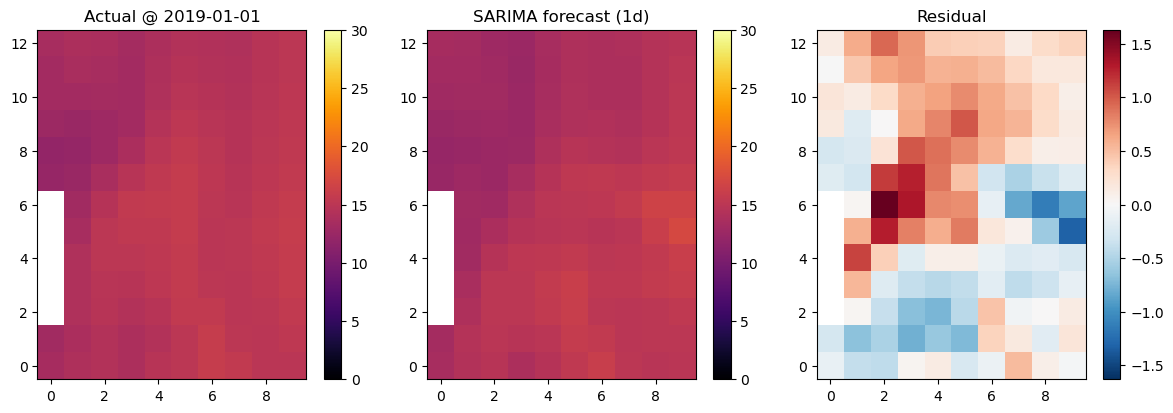


=== 7d ahead ===
MAE: 0.6067795140973399


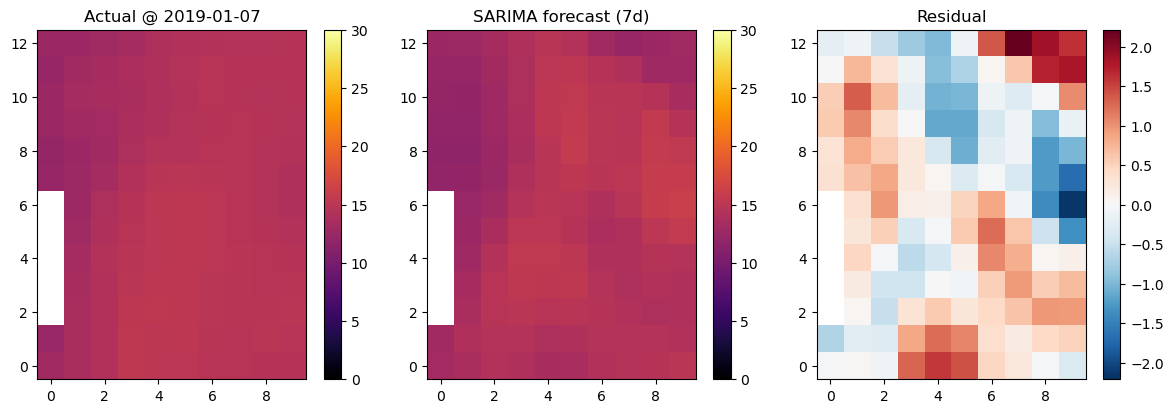


=== 30d ahead ===
MAE: 1.6443129393334621


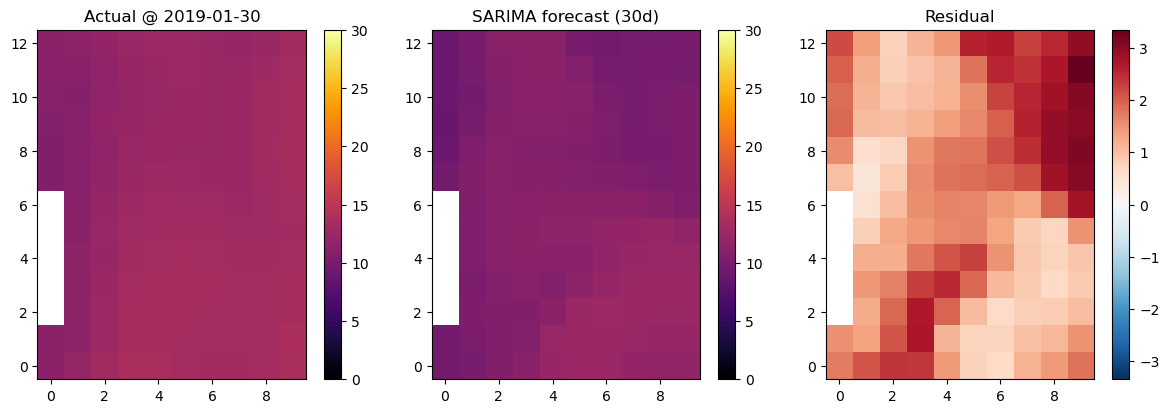

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============================================
# 0. 설정
# ============================================

DATA_ROOT = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\data\dataset_2017_to_2020-01"
csv_path  = os.path.join(DATA_ROOT, "depth_0p0.csv")

CUTOFF_DATE = "2019-01-01"

# 확정된 SARIMA 설정
ORDER = (1,0,0)
SEASONAL_ORDER = (0,1,0)
SEASONAL_PERIOD_DAYS = 365   # 1년 계절성

# 리드타임 (일 단위)
HORIZON_DAYS = {
    "1d": 1,
    "7d": 7,
    "30d": 30,
}

# ============================================
# 1. 데이터 로딩
# ============================================

df = pd.read_csv(csv_path)

# depth 제거
if "depth" in df.columns:
    df = df.drop(columns=["depth"])

# 컬럼 자동 추출
cols = df.columns
time_col = [c for c in cols if "time" in c.lower()][0]
lat_col  = [c for c in cols if "lat"  in c.lower()][0]
lon_col  = [c for c in cols if "lon"  in c.lower()][0]
temp_candidates = [c for c in cols if c not in [time_col, lat_col, lon_col]]
temp_col = temp_candidates[0]

print("사용 컬럼:", time_col, lat_col, lon_col, temp_col)

# 통일된 이름으로 저장
_data = pd.DataFrame({
    "time": df[time_col],
    "lat":  df[lat_col].astype(float).round(2),
    "lon":  df[lon_col].astype(float).round(2),
    "temp": df[temp_col],
})

_data["time"] = pd.to_datetime(_data["time"])
_data = _data.sort_values("time").reset_index(drop=True)

# 3시간 시간축
T3 = np.sort(_data["time"].unique())
Y  = np.sort(_data["lat"].unique())
X  = np.sort(_data["lon"].unique())
nT3, nY_full, nX_full = len(T3), len(Y), len(X)

# ============================================
# 2. daily mean 생성
# ============================================

_data["date"] = _data["time"].dt.floor("D")

daily = (_data.groupby(["date","lat","lon"], as_index=False)["temp"]
         .mean()
         .sort_values("date")
         .reset_index())

D = pd.DatetimeIndex(daily["date"].unique()).sort_values()
nD = len(D)
print("daily 길이:", nD)

# lat/lon after downsample
Y_ds = Y[::2]     # 위도 downsample
nY = len(Y_ds)
X_ds = X.copy()   # 경도는 그대로
nX = len(X_ds)

print("grid:", nY, nX)

# 인덱스 매핑
d_map = {d:i for i,d in enumerate(D)}
y_map = {y:i for i,y in enumerate(Y_ds)}
x_map = {x:i for i,x in enumerate(X_ds)}

# ============================================
# 3. daily 텐서 생성 (nY, nX, nD)
# ============================================

tnsr_daily = np.full((nY, nX, nD), np.nan, dtype=float)

for _, row in daily.iterrows():
    lat = float(row["lat"])
    lon = float(row["lon"])
    if lat in y_map and lon in x_map:
        iy = y_map[lat]
        ix = x_map[lon]
        idd = d_map[row["date"]]
        tnsr_daily[iy, ix, idd] = float(row["temp"])

print("tnsr_daily shape:", tnsr_daily.shape)

# ============================================
# 4. train/test 분리 (daily)
# ============================================

cutoff = np.datetime64(CUTOFF_DATE)
train_mask = D < cutoff
test_mask  = D >= cutoff

cut_trng = np.max(np.where(train_mask))     # train 마지막
first_test_idx = cut_trng + 1

# ============================================
# 5. full-grid SARIMA 학습 & 예측
# ============================================

pred_maps = {name: np.full((nY,nX), np.nan) for name in HORIZON_DAYS.keys()}
max_h = max(HORIZON_DAYS.values())

for iy in range(nY):
    for ix in range(nX):

        series = tnsr_daily[iy, ix, :]

        if np.sum(~np.isnan(series[:cut_trng+1])) < 30:
            continue

        s = pd.Series(series).replace([np.inf,-np.inf], np.nan)
        s = s.interpolate(limit_direction="both")

        # SARIMA(1,0,0)x(0,1,0,365)
        try:
            model = SARIMAX(
                s.values[:cut_trng+1],
                order=ORDER,
                seasonal_order=(SEASONAL_ORDER[0], SEASONAL_ORDER[1], SEASONAL_ORDER[2], SEASONAL_PERIOD_DAYS),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)
            fc = res.get_forecast(steps=max_h)
            yhat = fc.predicted_mean

            for name, h in HORIZON_DAYS.items():
                pred_maps[name][iy, ix] = yhat[h-1]

        except Exception:
            last = s.values[cut_trng]
            for name in HORIZON_DAYS.keys():
                pred_maps[name][iy, ix] = last

print("SARIMA full-grid 예측 완료.")

# ============================================
# 6. 평가 (daily 기준)
# ============================================

for name, h in HORIZON_DAYS.items():
    idx = first_test_idx + (h-1)
    if idx >= len(D):
        print(f"{name} ahead: 평가 위치 초과 → skip")
        continue

    actual = tnsr_daily[:,:,idx]
    pred   = pred_maps[name]
    err    = actual - pred

    mae = np.nanmean(np.abs(err))
    print(f"\n=== {name} ahead ===")
    print("MAE:", mae)

    vmin, vmax = 0, 30
    vmax_r = np.nanmax(np.abs(err))

    fig, axes = plt.subplots(1,3,figsize=(12,4))

    im0 = axes[0].imshow(actual,origin="lower",cmap="inferno",vmin=vmin,vmax=vmax)
    axes[0].set_title(f"Actual @ {D[idx].date()}")
    plt.colorbar(im0,ax=axes[0])

    im1 = axes[1].imshow(pred,origin="lower",cmap="inferno",vmin=vmin,vmax=vmax)
    axes[1].set_title(f"SARIMA forecast ({name})")
    plt.colorbar(im1,ax=axes[1])

    im2 = axes[2].imshow(err,origin="lower",cmap="RdBu_r",vmin=-vmax_r,vmax=vmax_r)
    axes[2].set_title("Residual")
    plt.colorbar(im2,ax=axes[2])

    plt.tight_layout()
    plt.show()



=== Horizon-wise MAE ===
1d ahead: MAE = 0.4502
7d ahead: MAE = 0.6068
30d ahead: MAE = 1.6443


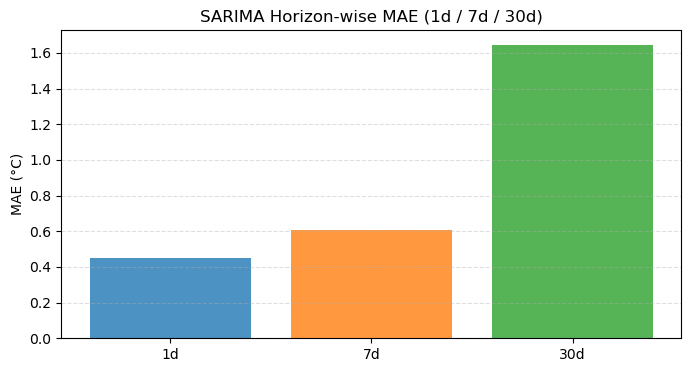

In [12]:
# ============================================
# 7. 전체 MAE 타임시리즈 계산 (daily 기준)
# ============================================

# daily 기반 예측은 horizon별 1개 시점만 비교했지만,
# "전 test 기간 동안 SARIMA의 일별 예측 성능"도 보고 싶다면
# SARIMA를 rolling forecast 형태로 돌려야 함.
# 여기서는 단기 horizon 평가를 위해,
# 각 horizon에 대해 예측된 시점의 MAE만 time series 형태로 나타냄.

mae_series = {}

for name, h in HORIZON_DAYS.items():
    idx = first_test_idx + (h - 1)
    if idx >= len(D):
        continue

    actual = tnsr_daily[:, :, idx]
    pred   = pred_maps[name]
    err    = actual - pred
    mae    = np.nanmean(np.abs(err))

    mae_series[name] = mae

# 출력
print("\n=== Horizon-wise MAE ===")
for name in mae_series:
    print(f"{name} ahead: MAE = {mae_series[name]:.4f}")

# ============================================
# 8. (NEW) MAE 시계열 그래프: multi-horizon
# ============================================

plt.figure(figsize=(8,4))
names = list(mae_series.keys())
values = [mae_series[n] for n in names]

plt.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
plt.ylabel("MAE (°C)")
plt.title("SARIMA Horizon-wise MAE (1d / 7d / 30d)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


daily train length: 729
daily test length : 396
train 기간: 2017-01-01 00:00:00 ~ 2018-12-31 00:00:00
test  기간: 2019-01-01 00:00:00 ~ 2020-01-31 00:00:00


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

pred_1step shape: (13, 10, 396)
평균 MAE (전체 test 기간): 0.6045165159217816


C:\Users\kjhye\AppData\Local\Temp\ipykernel_24000\2591572212.py:93: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kjhye\AppData\Local\Temp\ipykernel_24000\2591572212.py:93: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kjhye\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kjhye\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


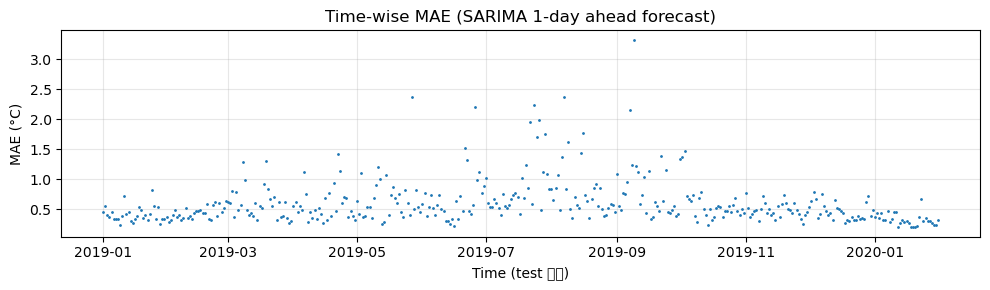

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -----------------------------------------
# 1. 기본 정보 확인
# -----------------------------------------
nY, nX, nD = tnsr_daily.shape

D_train = D[train_mask]
D_test  = D[test_mask]

first_test_idx = np.where(test_mask)[0][0]   # test 시작 index
nTest = len(D_test)

print("daily train length:", len(D_train))
print("daily test length :", nTest)
print("train 기간:", D_train[0], "~", D_train[-1])
print("test  기간:", D_test[0],  "~", D_test[-1])

# -----------------------------------------
# 2. SARIMA 1-step ahead 예측 (daily)
#    - 각 격자별로 전체 시계열(2017~2020)을 이용해 fit
#    - test 구간에 대해 1-step ahead forecast 생성
# -----------------------------------------

ORDER = (1, 0, 0)
SEASONAL_PERIOD_DAYS = 365
SEASONAL_ORDER = (0, 1, 0, SEASONAL_PERIOD_DAYS)

pred_1step = np.full((nY, nX, nTest), np.nan, dtype=float)

for iy in range(nY):
    for ix in range(nX):

        series = tnsr_daily[iy, ix, :]

        # train에 유효한 값이 너무 적으면 skip
        if np.sum(~np.isnan(series[train_mask])) < 30:
            continue

        s = pd.Series(series).replace([np.inf, -np.inf], np.nan)
        s = s.interpolate(limit_direction="both")

        try:
            model = SARIMAX(
                s.values,            # 전체(2017~2020) 사용
                order=ORDER,
                seasonal_order=SEASONAL_ORDER,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)

            # train 마지막 이후부터 끝까지 1-step ahead 예측
            # (dynamic=False → 각 시점에서 직전까지의 실제값 사용)
            fc = res.predict(start=first_test_idx, end=nD-1, dynamic=False)

            if len(fc) != nTest:
                fc = fc[:nTest]

            pred_1step[iy, ix, :] = fc

        except Exception as e:
            # 실패하면 그냥 NaN (해당 격자는 MAE 계산에서 빠짐)
            print(f"SARIMA 실패: iy={iy}, ix={ix}, msg={e}")

print("pred_1step shape:", pred_1step.shape)

# -----------------------------------------
# 3. 시간별 MAE 계산 (격자 평균)
# -----------------------------------------

test_daily = tnsr_daily[:, :, test_mask]   # 실제값 (test 구간)
err = test_daily - pred_1step             # (nY, nX, nTest)

# 각 날짜마다 (위도,경도 평균) MAE
mae_t = np.nanmean(np.abs(err), axis=(0, 1))

print("평균 MAE (전체 test 기간):", float(np.nanmean(mae_t)))

# -----------------------------------------
# 4. Time-wise MAE scatter plot
# -----------------------------------------

plt.figure(figsize=(10, 3))
plt.plot(D_test, mae_t, marker=".", linestyle="None", markersize=2)
plt.title("Time-wise MAE (SARIMA 1-day ahead forecast)")
plt.xlabel("Time (test 기간)")
plt.ylabel("MAE (°C)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
